In [1]:
import matplotlib.pyplot as plt
from matplotlib.widgets import Cursor 
import numpy as np

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()

from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Probe.Plot import plot
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
from PySpice.Spice.HighLevelElement import PulseVoltageSource

In [165]:
import re
import time

def Unit_2_Numpy_List(values):
    return [float(re.search('^[^\s]*', str(x)).group(0)) for x in values]

In [85]:
####################################################################################################

from PySpice.Spice.Netlist import SubCircuitFactory
from PySpice.Unit import *

####################################################################################################

class Transformer(SubCircuitFactory):

    NAME = 'Transformer'
    NODES = ('input_plus', 'input_minus',
             'output_plus', 'output_minus')

    ##############################################

    def __init__(self,
                 turn_ratio,
                 primary_inductance=1@u_H,
                 copper_resistance=1@u_Ω,
                 leakage_inductance=1@u_mH,
                 winding_capacitance=20@u_pF,
                 coupling=.999,
             ):

        super().__init__()

        # For an ideal transformer you can reduce the values for the flux leakage inductances, the
        # copper resistors and the winding capacitances. But
        if copper_resistance <= 0:
            raise ValueError("copper resistance must be > 0")
        if leakage_inductance <= 0:
            raise ValueError("leakage inductance must be > 0")

        secondary_inductance = primary_inductance / float(turn_ratio**2)

        # Primary
        self.C('primary', 'input_plus', 'input_minus', winding_capacitance)
        self.L('primary_leakage', 'input_plus', 1, leakage_inductance)
        primary_inductor = self.L('primary', 1, 2, primary_inductance)
        self.R('primary', 2, 'output_minus', copper_resistance)

        # Secondary
        self.C('secondary', 'output_plus', 'output_minus', winding_capacitance)
        self.L('secondary_leakage', 'output_plus', 3, leakage_inductance)
        secondary_inductor = self.L('secondary', 3, 4, secondary_inductance)
        self.R('secondary', 4, 'output_minus', copper_resistance)

        # Coupling
        self.CoupledInductor('coupling', primary_inductor.name, secondary_inductor.name, coupling)

In [178]:
# Simulation variables
STEP = 1@u_us
END = 80@u_ms

class Switch(SubCircuitFactory):
    NAME = 'Switch'
    NODES = ('input', 'output')
    
    def __init__(self, 
                 # plus, 
                 # minus,  
                 start = END/8, 
                 end = END/2, 
                 STEP_SIMULATION = STEP, 
                 END_SIMULATION = END,
                 init_state = 'off'):
        
        super().__init__()
        
        assert start < end, f'Please enter a end = {end} time greater than start{start}'
        if isinstance(end,tuple):
            end = list(end)[0]
        if isinstance(start,tuple):
            start = list(start)[0]
        if isinstance(END_SIMULATION,tuple):
            END_SIMULATION = list(END_SIMULATION)[0]
        if isinstance(STEP_SIMULATION,tuple):
            STEP_SIMULATION = list(STEP_SIMULATION)[0]

        # Defining the switch model
        self.model('mysw', 'SW', Ron=1e-12, Roff=1e12)

        # Pulse definitions
        initial_value = -10@u_V 
        pulsed_value = 10@u_V
        pulse_width = end-start                 # Can control a window 
        period =  END_SIMULATION                # Just one Pulse 
        delay_time= start                       # Starting time f the pulse 
        rise_time = STEP_SIMULATION
        fall_time = STEP_SIMULATION
        # phase=None
        # dc_offset=0
        
        self.PulseVoltageSource('Controller', 'C', self.gnd,
            initial_value, pulsed_value, pulse_width, period, delay_time, rise_time, fall_time)

        # Voltage controled switch
        # Controlled by ('C', self.gnd)
        # Close points ('A', 'B')
        self.VCS('VCS', 'input', 'output', 'C', self.gnd, model = 'mysw', initial_state = init_state)
        
def add_switch(circuit,
               name,
                P1,
                P2,
                start = 10@u_ms, 
                end = 20@u_ms, 
                STEP_SIMULATION = STEP, 
                END_SIMULATION = END,
                init_state = 'off'):
        
        circuit.subcircuit(Switch(  
                            start, 
                            end, 
                            STEP_SIMULATION, 
                            END_SIMULATION,
                            init_state))
        circuit.X(name, 'Switch', P1, P2)

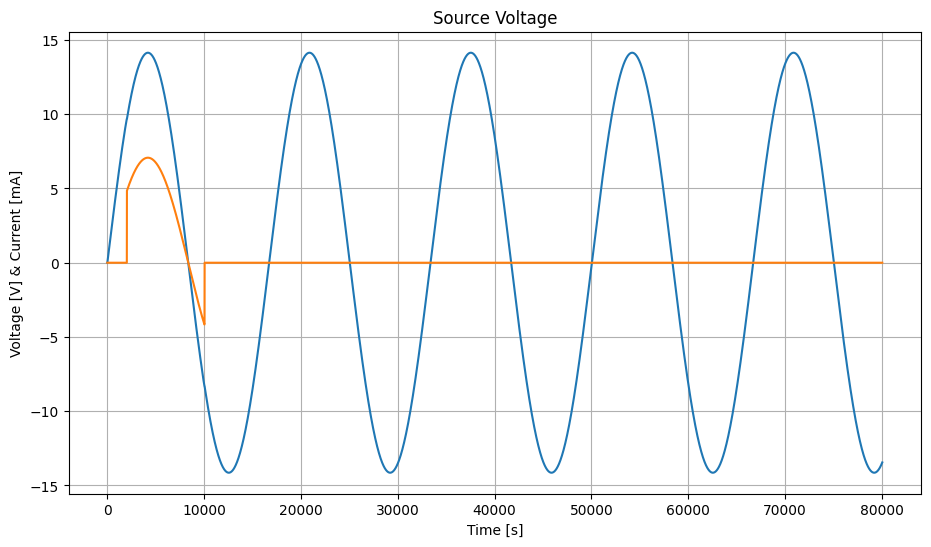

In [179]:
# Simulation variables
STEP = 1@u_us
END = 80@u_ms

circuit = Circuit('Teste')

# Sine Source
Vrms = 10
A=Vrms*np.sqrt(2)@u_V
f=60@u_Hz
source = circuit.SinusoidalVoltageSource('Source', '1', circuit.gnd, amplitude=A, frequency=f)

add_switch( circuit,
            'S1',
            '1',
            '2',
            start = 10@u_ms, 
            end = 20@u_ms, 
            STEP_SIMULATION = STEP, 
            END_SIMULATION = END,
            init_state = 'off')
circuit.R('R', '2','3', 10@u_Ω)
add_switch( circuit,
            'S2',
            '3',
            '4',
            start = 2@u_ms, 
            end = 10@u_ms, 
            STEP_SIMULATION = STEP, 
            END_SIMULATION = END,
            init_state = 'off')
circuit.R('LOAD', '4',circuit.gnd, 10@u_Ω)

######################################################################
# CIRCUIT SIMULATION

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.transient(step_time=STEP, end_time=END)

# Verifying the source 

plt.figure(figsize=(11, 6))
plt.title('Source Voltage')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V] & Current [mA]')
plt.grid()
plt.plot(analysis['1'])
plt.plot(analysis['4'])

In [23]:
class Rectifier_Transformer(Circuit):
    def __init__(self, Vrms, f, start = END/8, end = END/2, STEP_SIMULATION = STEP, END_SIMULATION = END, **kwargs):
        super().__init__(title='Full Bridge Rectifier with Switch intialization', **kwargs)

        # MUST be defined after the circuit call
        # Defining the 1N4002 model by its especifications
        self.model('1N4002', 'D', IS = 14.11E-11, N = 1.984, RS = 33.89E-3, IKF=94.81, XTITUN=3, KEG=1.110, CJO = 51.17E-12, M = .2762, VJ = .3905, FC = 0.5, ISR=100.0E-12, NR=2, BV=100.1, IBV=10, TT = 4.761E-6)
        # Defining the 1N751 model by its especifications
        self.model('1N751', 'D', IS = 1.004E-15, N = 1, RS = .5875, IKF=0, XTITUN=3, EG=1.11, CJO = 160E-12, M = .5484, VJ = 0.75, FC = 0.5, ISR=1.8E-9, NR=2, BV=5.1, IBV=27.721E-3, NBV=1.1779)

        # Sine Source
        A=Vrms*np.sqrt(2)
        source = self.SinusoidalVoltageSource('Source', 'Vs', self.gnd, amplitude=A, frequency=f)

        # Adding resistance to measure current
        self.R('Rc', 'Vs', 'S', 1@u_Ω) 
        # self.C('C_drain', 'S', self.gnd, 10@u_mF) 
        
        # Switch to turn ON
        self.subcircuit(Switch(start, end, STEP_SIMULATION, END_SIMULATION, 'off'))
        self.X('S', 'Switch', 'S', 'pri')
        
        # Transformer definitions
        turn_ratio = 20
        primary_inductance=100@u_H
        copper_resistance=1@u_mΩ
        leakage_inductance=1@u_uH
        winding_capacitance=0@u_pF
        coupling=0.9999
        self.subcircuit(Transformer(turn_ratio,primary_inductance,copper_resistance,leakage_inductance,winding_capacitance,coupling))

        # When using circuit.X the class defined before is stated after the element name, in this case the word
        # Transformer ( second word ) is calling the class Transformer defined before
        self.X('transformer', 'Transformer', 'pri', self.gnd, 'sec_plus', 'sec_minus')

        # Diode bridge
        # Here we are calling the defined element befeore by stating its model with the kwarg "model" in the end
        self.D('D1', 'sec_plus', 'smooth', model='1N4002')
        self.D('D2', self.gnd, 'sec_plus', model='1N4002')
        self.D('D3', self.gnd, 'sec_minus', model='1N4002')
        self.D('D4', 'sec_minus', 'smooth', model='1N4002')

        # RC filter 
        self.R('R_1', 'smooth', 'output', 100@u_Ω)
        self.C('1', 'smooth', self.gnd, 1@u_mF)
        
        # Zener and LOAD
        self.D('Z1', 'output', self.gnd, model='1N751') 
        self.R('load', 'output', self.gnd, 100@u_Ω)

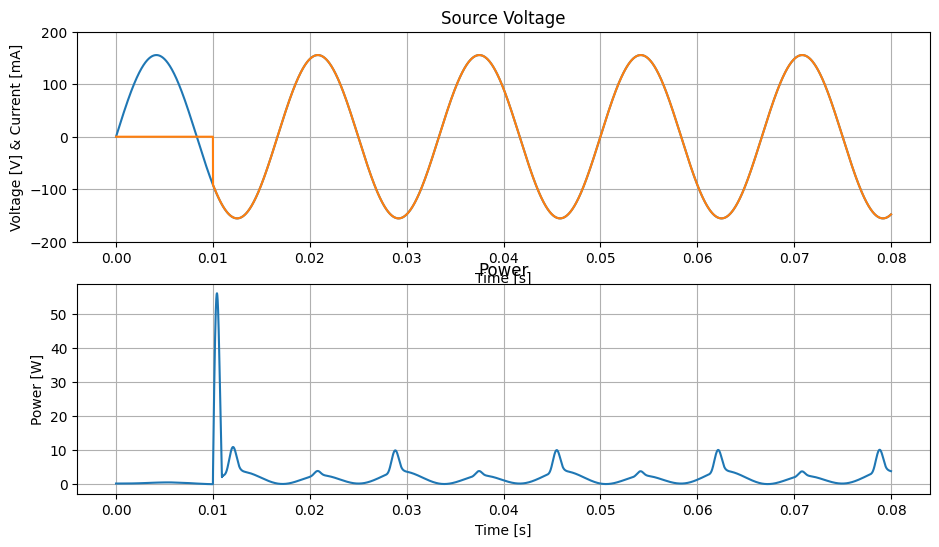

In [40]:
STEP = 1@u_us
END = 80@u_ms

Vrms = 110@u_V
f = 60@u_Hz
start = 10@u_ms, 
end = 80@u_ms, 
STEP_SIMULATION = STEP, 
END_SIMULATION = END

# del circuit
# del circuit_rec
circuit_rec = Rectifier_Transformer(Vrms, f, start, end, STEP_SIMULATION, END_SIMULATION)
#######################################################################
# CIRCUIT SIMULATION

simulator = circuit_rec.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.transient(step_time=STEP, end_time=END)
#######################################################################
# PLOTS

plt.figure(figsize=(11, 6))
plt.subplot(2,1,1)
plt.title('Source Voltage')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V] & Current [mA]')
plt.grid()
plot(analysis['Vs'])
plot(analysis['pri'])
plt.ylim((-200, 200))

plt.subplot(2,1,2)
plt.title('Power')
plt.xlabel('Time [s]')
plt.ylabel('Power [W]')
plt.grid()
plot((analysis['Vs']-analysis['pri'])*analysis['pri'])
# plt.ylim((-200, 200))

In [41]:
class Rectifier_FullBridge(Circuit):
    def __init__(self, Vrms, f, start = END/8, end = END/2, STEP_SIMULATION = STEP, END_SIMULATION = END, **kwargs):
        super().__init__(title='Full Bridge Rectifier with Switch intialization', **kwargs)

        # MUST be defined after the circuit call
        # Defining the 1N4002 model by its especifications
        self.model('1N4002', 'D', IS = 14.11E-11, N = 1.984, RS = 33.89E-3, IKF=94.81, XTITUN=3, KEG=1.110, CJO = 51.17E-12, M = .2762, VJ = .3905, FC = 0.5, ISR=100.0E-12, NR=2, BV=100.1, IBV=10, TT = 4.761E-6)
        # Defining the 1N751 model by its especifications
        self.model('1N751', 'D', IS = 1.004E-15, N = 1, RS = .5875, IKF=0, XTITUN=3, EG=1.11, CJO = 160E-12, M = .5484, VJ = 0.75, FC = 0.5, ISR=1.8E-9, NR=2, BV=5.1, IBV=27.721E-3, NBV=1.1779)

        # Sine Source
        A=Vrms*np.sqrt(2)
        source = self.SinusoidalVoltageSource('Source', 'Vs', self.gnd, amplitude=A, frequency=f)

        # Adding resistance to measure current
        self.R('Rc', 'Vs', 'IN', 1@u_Ω) 
        # self.C('C_drain', 'S', self.gnd, 10@u_mF) 
        
        # Switch to turn ON
        self.subcircuit(Switch(start, end, STEP_SIMULATION, END_SIMULATION, 'off'))
        self.X('SW', 'Switch', 'IN', 'S')

        # Diode bridge
        # Here we are calling the defined element befeore by stating its model with the kwarg "model" in the end
        self.D('D1', 'S', '1', model='1N4002')
        self.D('D2', 'ref', 'S', model='1N4002')
        self.D('D3', 'ref', self.gnd, model='1N4002')
        self.D('D4', self.gnd, '1', model='1N4002')

        # RC filter
        self.C('C', '1', 'ref', 1@u_mF)
        self.R('R_1', '1', 'OUT', 100@u_Ω)
        
        
        # Zener and LOAD
        self.D('Z1', 'OUT', 'ref', model='1N751') 
        self.R('load', 'OUT', 'ref', 100@u_Ω)

In [47]:
STEP = 100@u_us
END = 80@u_ms

Vrms = 110@u_V
f = 60@u_Hz
start = 15@u_ms, 
end = 80@u_ms, 
STEP_SIMULATION = STEP, 
END_SIMULATION = END

# del circuit
# del circuit_rec
circuit = Rectifier_FullBridge(Vrms, f, start, end, STEP_SIMULATION, END_SIMULATION)
# print(circuit)

#######################################################################
# CIRCUIT SIMULATION

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.transient(step_time=STEP, end_time=END)

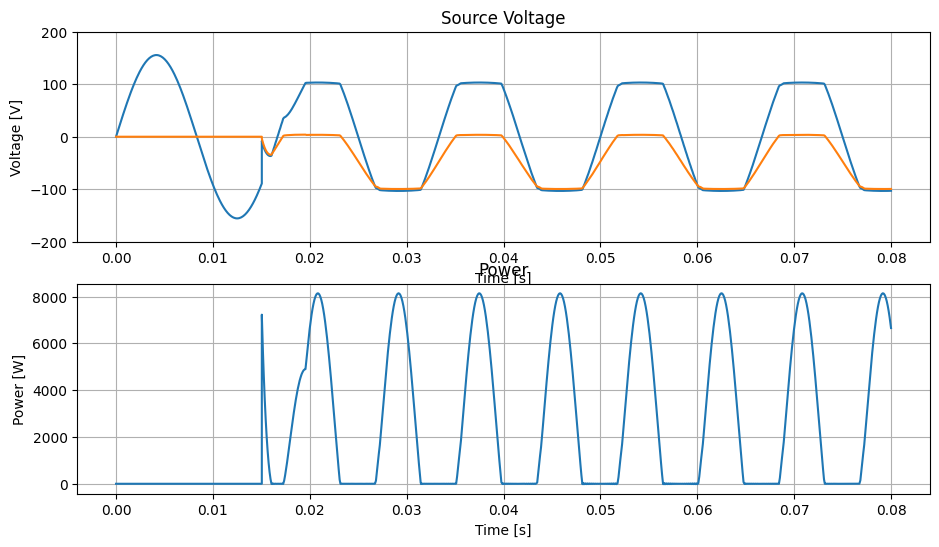

In [48]:
#######################################################################
# PLOTS

plt.figure(figsize=(11, 6))
plt.subplot(2,1,1)
plt.title('Source Voltage')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.grid()
plot(analysis['IN'])
plot(analysis['OUT'])
plt.ylim((-200, 200))

plt.subplot(2,1,2)
plt.title('Power')
plt.xlabel('Time [s]')
plt.ylabel('Power [W]')
plt.grid()
plot((analysis['Vs']-analysis['IN'])*analysis['Vs'])
# plt.ylim((-200, 200))
plt.show()